In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [2]:
def generate_gaussian_blob(image_size, mean, cov, angle, noise_std=0.01):
    """
    Generate a single Gaussian blob on an image with added random noise.
    """
    x, y = np.meshgrid(np.linspace(0, image_size[0] - 1, image_size[0]),
                       np.linspace(0, image_size[1] - 1, image_size[1]))
    x -= mean[0]
    y -= mean[1]

    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    x_rot = cos_angle * x + sin_angle * y
    y_rot = -sin_angle * x + cos_angle * y

    exponent = (x_rot ** 2) / (2 * cov[0] ** 2) + (y_rot ** 2) / (2 * cov[1] ** 2)
    blob = np.exp(-exponent)

    # Add random noise centered around the Gaussian blob
    noise = np.random.normal(0, noise_std, blob.shape)
    blob += noise

    return blob

def create_training_data(num_samples, image_size=(128, 48), num_blobs=5, noise_std=0.05, crop_box_size = 20):
    """
    Create training data with Gaussian blobs and noise for the YOLO-style model.
    """
    X = np.zeros((num_samples, image_size[1], image_size[0], 1), dtype=np.float32)
    y = np.zeros((num_samples, num_blobs, 5), dtype=np.float32)
    crop_boxes_pixel = np.zeros((num_samples, num_blobs, 4), dtype=np.float32)
    crop_boxes_norm = np.zeros((num_samples, num_blobs, 4), dtype=np.float32)

    for i in range(num_samples):
        image = np.zeros((image_size[1], image_size[0]), dtype=np.float32)
        blob_params = []

        # Generate y-values within 20% of each other
        base_y = np.random.uniform(0.4 * image_size[1], 0.6 * image_size[1])
        y_values = np.random.uniform(base_y * 0.8, base_y * 1.2, num_blobs)

        # Generate evenly spaced x-values with slight variation
        x_values = np.linspace(0, image_size[0], num_blobs + 2)[1:-1]
        x_values += np.random.uniform(-5, 5, num_blobs)

        for j in range(num_blobs):
            mean_x = x_values[j]
            mean_y = y_values[j]
            cov_x = np.random.uniform(2, 6)
            cov_y = np.random.uniform(1, 5)
            theta = np.random.uniform(-10, 10) * np.pi / 180  # Cap rotation at 10 degrees
            blob = generate_gaussian_blob((image_size[0], image_size[1]), (mean_x, mean_y), (cov_x, cov_y), theta, noise_std)
            image += blob

            # Store parameters for the label
            blob_params.append((mean_x, mean_y, cov_x, cov_y, theta))

            # Crop box for each blob
            crop_boxes_pixel[i, j, 0] = x_values[j] - crop_box_size//2 # leftmost border
            crop_boxes_pixel[i, j, 1] = x_values[j] + crop_box_size//2 # rightmost border
            crop_boxes_pixel[i, j, 2] = y_values[j] - crop_box_size//2 # top border
            crop_boxes_pixel[i, j, 3] = y_values[j] + crop_box_size//2 # bottom border

            # Normalized crop box coordinates
            crop_boxes_norm[i, j, 0] = crop_boxes_pixel[i, j, 0]/image_size[0] # leftmost border
            crop_boxes_norm[i, j, 1] = crop_boxes_pixel[i, j, 1]/image_size[0] # rightmost border
            crop_boxes_norm[i, j, 2] = crop_boxes_pixel[i, j, 2]/image_size[1] # top border
            crop_boxes_norm[i, j, 3] = crop_boxes_pixel[i, j, 3]/image_size[1] # bottom border

        # Convert parameters to labels
        for j in range(num_blobs):
            mean_x, mean_y, cov_x, cov_y, theta = blob_params[j]
            y[i, j, :] = [mean_x, mean_y, cov_x, cov_y, theta]

        X[i, :, :, 0] = np.clip(image, 0, 1)

    return X, y, crop_boxes_pixel, crop_boxes_norm

def plot_borders_pixel(ax, crop_boxes_pixel):
    num_blobs = crop_boxes_pixel.shape[0]
    for j in range(num_blobs):
        cbp = crop_boxes_pixel[j]
        ax.plot([cbp[0], cbp[1]], [cbp[2], cbp[2]], color='blue') # top
        ax.plot([cbp[0], cbp[1]], [cbp[3], cbp[3]], color='blue') # bottom
        ax.plot([cbp[0], cbp[0]], [cbp[2], cbp[3]], color='blue') # left
        ax.plot([cbp[1], cbp[1]], [cbp[2], cbp[3]], color='blue') # right

def plot_borders_norm(ax, crop_boxes_norm, image_size=(128, 48)):
    num_blobs = crop_boxes_norm.shape[0]
    for j in range(num_blobs):
        cbn = crop_boxes_norm[j].copy()
        cbn[0] = cbn[0]*image_size[0]
        cbn[1] = cbn[1]*image_size[0]
        cbn[2] = cbn[2]*image_size[1]
        cbn[3] = cbn[3]*image_size[1]
        ax.plot([cbn[0], cbn[1]], [cbn[2], cbn[2]], color='blue') # top
        ax.plot([cbn[0], cbn[1]], [cbn[3], cbn[3]], color='blue') # bottom
        ax.plot([cbn[0], cbn[0]], [cbn[2], cbn[3]], color='blue') # left
        ax.plot([cbn[1], cbn[1]], [cbn[2], cbn[3]], color='blue') # right

X_train shape = (num_samples, image_size[1], image_size[0], 1) =  (2, 48, 128, 1)
y_train shape = (num_samples, num_blobs, 5) =  (2, 5, 5)
crop_boxes_pixel shape = (num_samples, num_blobs, 4) =  (2, 5, 4)
crop_boxes_norm shape = (num_samples, num_blobs, 4) =  (2, 5, 4)


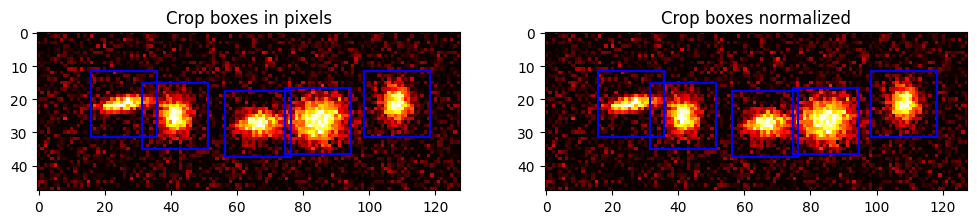

In [3]:
num_samples = 2  # Number of training samples
X_train, y_train, crop_boxes_pixel, crop_boxes_norm = create_training_data(num_samples, noise_std=0.05)

print("X_train shape = (num_samples, image_size[1], image_size[0], 1) = ", X_train.shape)
print("y_train shape = (num_samples, num_blobs, 5) = ", y_train.shape)
print("crop_boxes_pixel shape = (num_samples, num_blobs, 4) = ", crop_boxes_pixel.shape)
print("crop_boxes_norm shape = (num_samples, num_blobs, 4) = ", crop_boxes_norm.shape)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(X_train[0].squeeze(), cmap='hot')
axes[1].imshow(X_train[0].squeeze(), cmap='hot')
plot_borders_pixel(axes[0], crop_boxes_pixel[0])
plot_borders_norm(axes[1], crop_boxes_norm[0])
axes[0].set_title("Crop boxes in pixels")
axes[1].set_title("Crop boxes normalized")
plt.show(fig)

In [5]:
class CropLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CropLayer, self).__init__(**kwargs)

    def call(self, inputs):
        image, crop_boxes = inputs
        batch_size = tf.shape(image)[0]
        num_boxes = tf.shape(crop_boxes)[1]
        crop_boxes = tf.reshape(crop_boxes, (batch_size * num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=num_boxes)
        
        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, (20, 20)
        )
        
        return cropped_images

# 1. If we crop in pixel coordinates

cropped_images.shape = (num_samples*num_blobs, 20, 20, 1): (10, 20, 20, 1)
cropped_images.shape = (num_samples*num_blobs, 20, 20): (10, 20, 20)


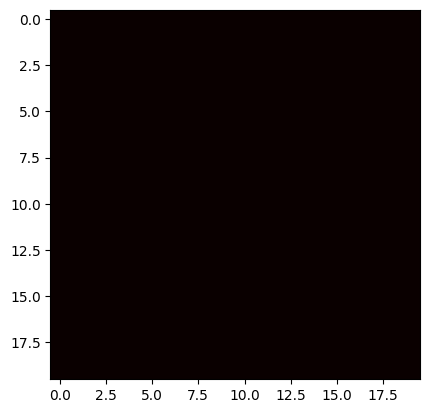

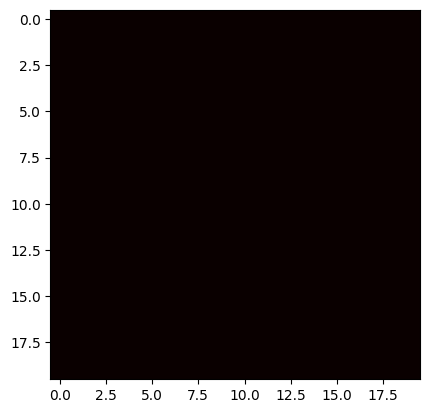

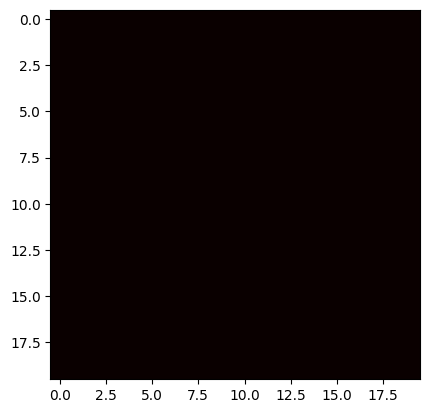

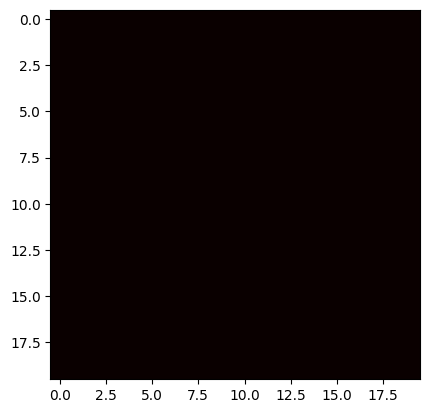

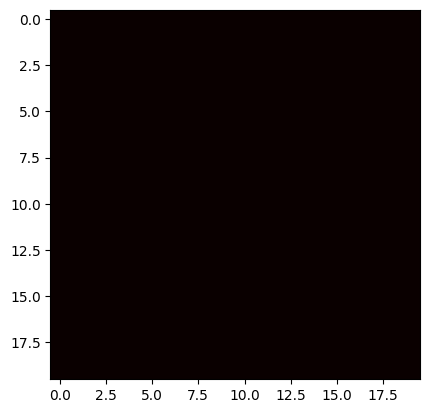

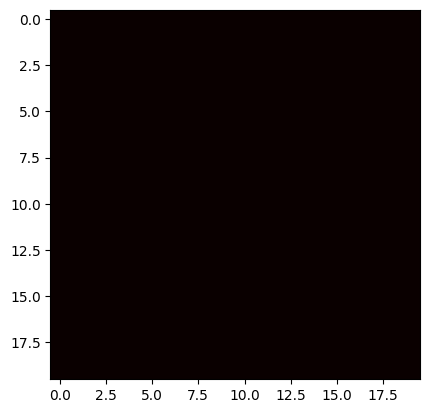

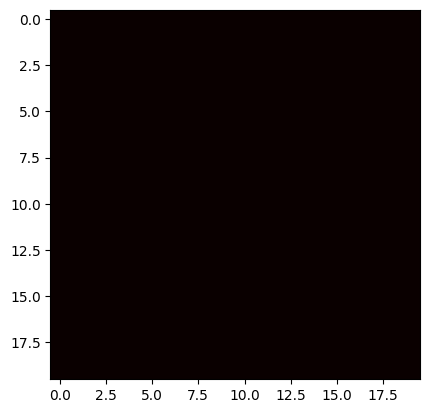

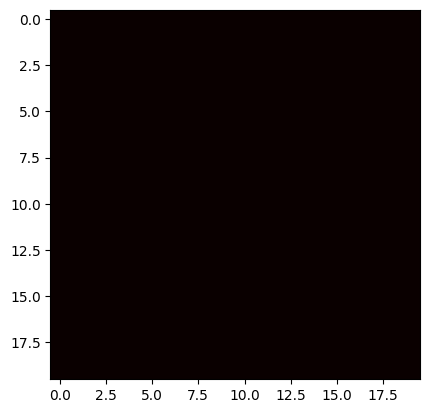

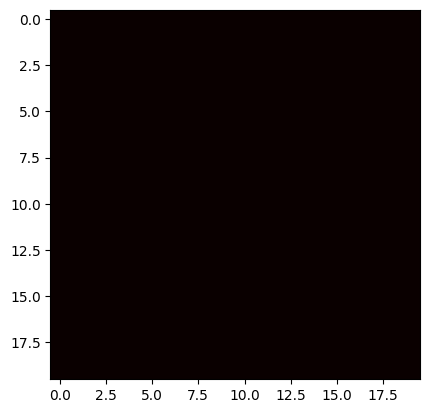

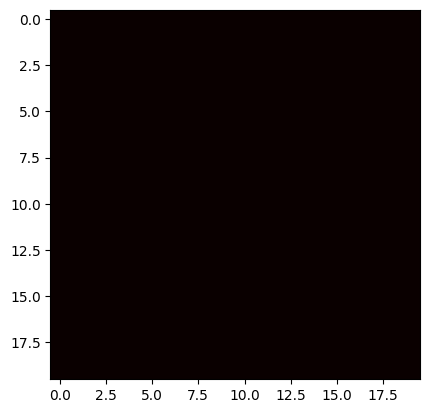

In [6]:
crop_layer = CropLayer()
cropped_images = crop_layer([X_train, crop_boxes_pixel])
print(f"cropped_images.shape = (num_samples*num_blobs, 20, 20, 1): {cropped_images.shape}")

cropped_images = cropped_images.numpy().squeeze()
print(f"cropped_images.shape = (num_samples*num_blobs, 20, 20): {cropped_images.shape}")
for i in range(cropped_images.shape[0]):
    plt.figure()
    plt.imshow(cropped_images[i], cmap='hot')
    plt.show()
    plt.close()


# 2. If we crop in normalized coordinates

cropped_images.shape = (num_samples*num_blobs, 20, 20, 1): (10, 20, 20, 1)
cropped_images.shape = (num_samples*num_blobs, 20, 20): (10, 20, 20)


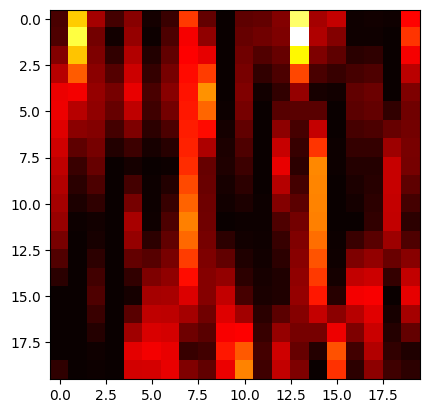

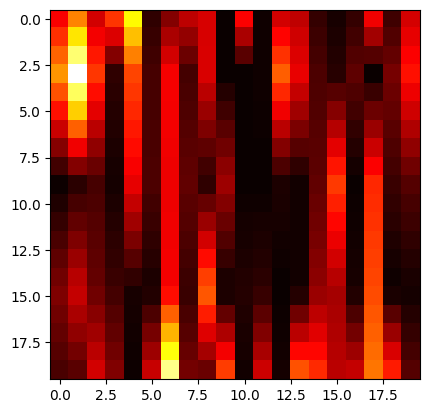

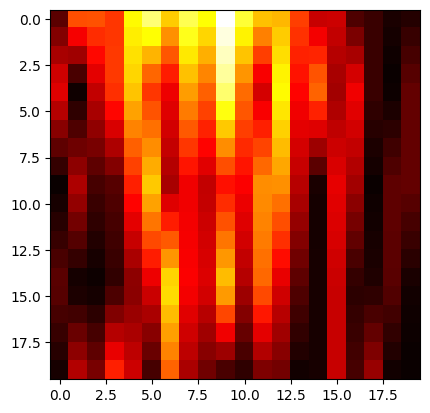

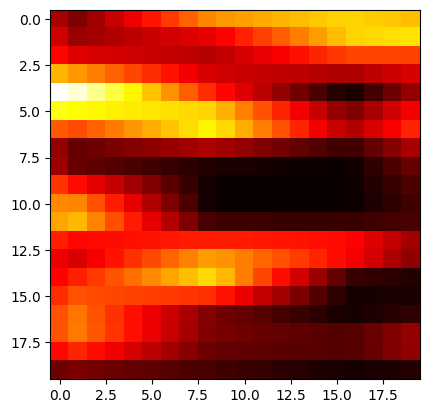

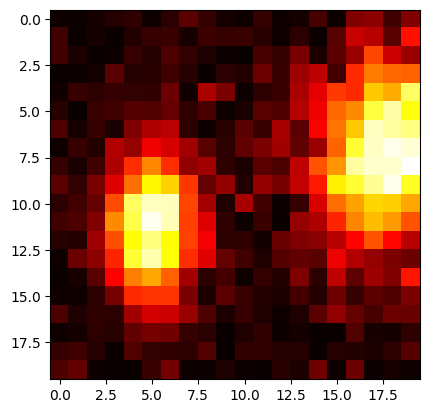

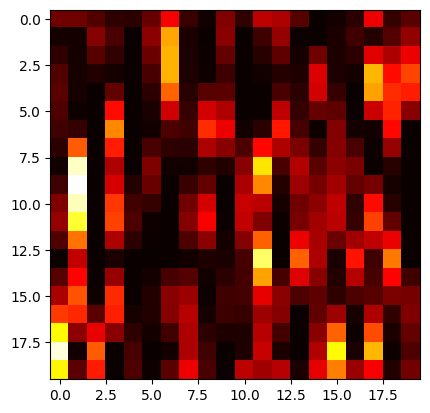

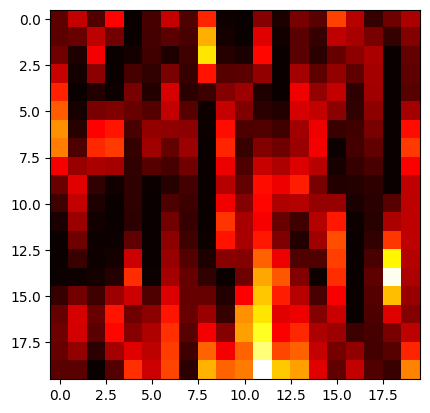

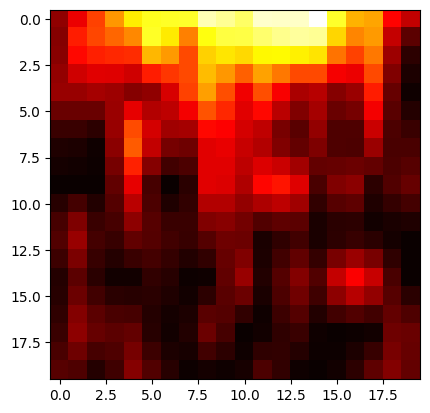

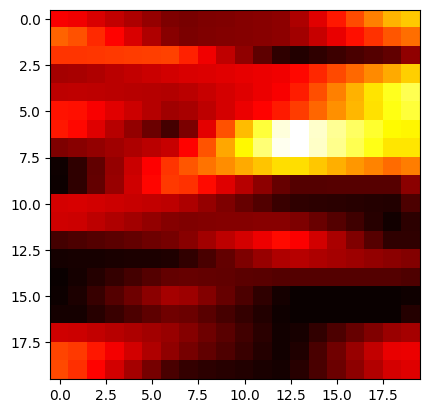

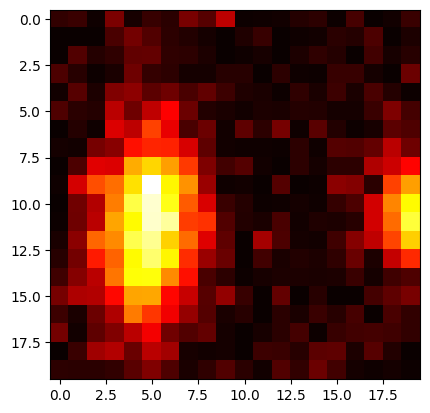

In [8]:
crop_layer = CropLayer()
cropped_images = crop_layer([X_train, crop_boxes_norm])
print(f"cropped_images.shape = (num_samples*num_blobs, 20, 20, 1): {cropped_images.shape}")

cropped_images = cropped_images.numpy().squeeze()
print(f"cropped_images.shape = (num_samples*num_blobs, 20, 20): {cropped_images.shape}")
for i in range(cropped_images.shape[0]):
    plt.figure()
    plt.imshow(cropped_images[i], cmap='hot')
    plt.show()
    plt.close()


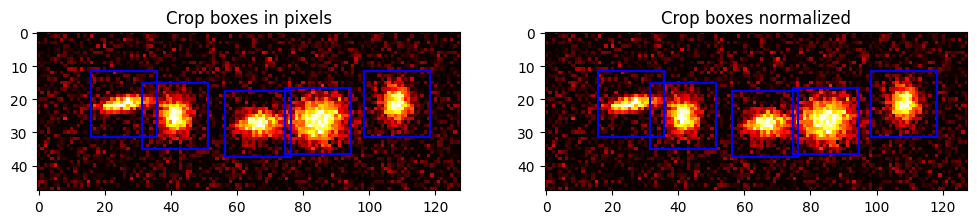

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(X_train[0].squeeze(), cmap='hot')
axes[1].imshow(X_train[0].squeeze(), cmap='hot')
plot_borders_pixel(axes[0], crop_boxes_pixel[0])
plot_borders_norm(axes[1], crop_boxes_norm[0])
axes[0].set_title("Crop boxes in pixels")
axes[1].set_title("Crop boxes normalized")
plt.show(fig)